# Pythorch Custom Datasets

In [1]:
import torch
from torch import nn

torch.__version__

'2.5.1+cu124'

In [2]:
# set decive agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Get the Data

Our Dataset is a subset of the food101 dataset.

Food101 has 101 different classes of food and 1000 images per class. (750 for training and 250 for testing)

Our dataset starts with 3 classes and only 10% of images (75 training images and 25 testing images)

When starting ML projects, it's important to start out on a small scale and then increase the scale if necessary.

The whole point is to speed up experiments.

In [3]:
import requests
import zipfile
from pathlib import Path

# setup path to a data folder
data_path = Path('data')
image_path = data_path / 'pizza_steak_sushi'

# if image folder doesn't exist, download and prepare it
if image_path.is_dir():
  print(f'{image_path} already exists skipping download')
else:
  print(f'{image_path} does not exist...creating one')
  image_path.mkdir(parents=True, exist_ok=True)

# download pizza steak and sushi data
with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
  request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip')
  print('Downloading pizza steak and sushi data...')
  f.write(request.content)

# unzip data
with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
  print('Unzipping data')
  zip_ref.extractall(image_path)
  print('Done!')

data/pizza_steak_sushi does not exist...creating one
Unzipping data
Done!


## Becoming One with the Data - Data Preparation and Exploration

In [4]:
import os
def walk_through_dir(dir_path):
  '''
  walk through dir path returing its contents
  '''
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak


In [6]:
# setup train and test paths
train_dir = image_path / 'train'
test_dir = image_path / 'test'

### Visulaizing an image

Write some code to:

1. get all image path
2. pick a random image path
3. Get image path name
4. Open the image with python pillow
5. We'll show the image and print metadata

Image Path: data/pizza_steak_sushi/train/pizza/667309.jpg
Image class: pizza
Image height: 384
Image Width: 512


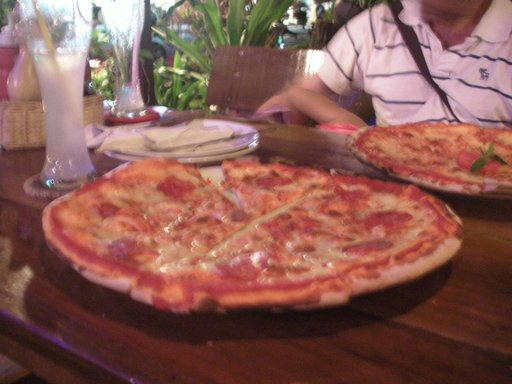

In [7]:
import random
from PIL import Image

random.seed(42)

# get all image paths
image_path_list = list(image_path.glob('*/*/*.jpg'))

# Pick a random image path
random_image_path  = random.choice(image_path_list)

# get image class from path name (imag class is the name of the directory)
image_class = random_image_path.parent.stem

# Open image
img = Image.open(random_image_path)

# Print metadata
print(f'Image Path: {random_image_path}')
print(f'Image class: {image_class}')
print(f'Image height: {img.height}')
print(f'Image Width: {img.width}')
img

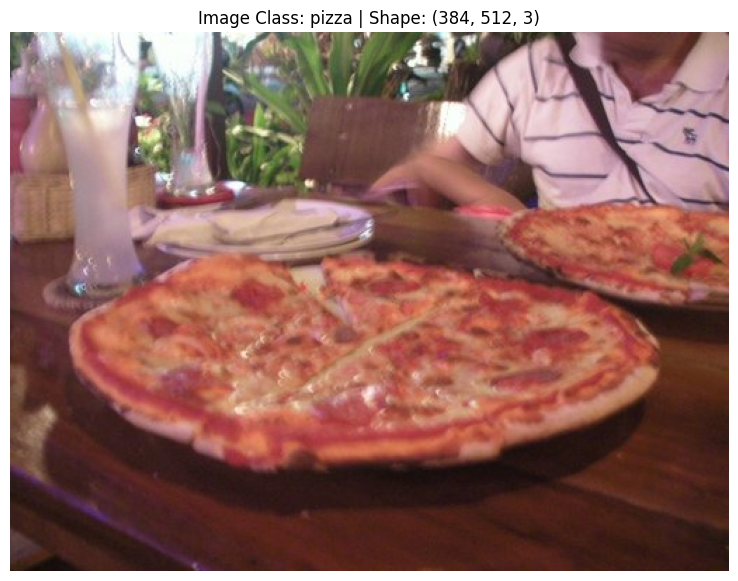

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# turn image into an array
img_as_array = np.asarray(img)

# plot the image with matplotlib
plt.figure(figsize = (10,7))
plt.imshow(img_as_array)
plt.title(f'Image Class: {image_class} | Shape: {img_as_array.shape}')
plt.axis(False);

## Transforming Data

Before we can our imag data with pytorch:

1. Turn our mages into tensors (numerical representation)
2. turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`

In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### Transforming Data with `torchvision.transform()`

In [10]:
# write a transform for an image
data_transform = transforms.Compose([
    # resize images
    transforms.Resize(size = (64,64)),
    # flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # turn the image into a torch tensor
    transforms.ToTensor()
])

In [11]:
data_transform(img).shape

torch.Size([3, 64, 64])

In [12]:
def plot_tansformed_images(image_paths, transform, n = 3, seed=None):
  '''
  collects random images and loads and transforms them
  plots the original and trnasformed version
  '''
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k = n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f'Original\nSize: {f.size}')
      ax[0].axis(False)

      # trasform and plot imaage
      transformed_image = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f'Transformed\nSize: {transformed_image.shape}')
      ax[1].axis(False)

      fig.suptitle(f'Class: {image_path.parent.stem}', fontsize = 14)



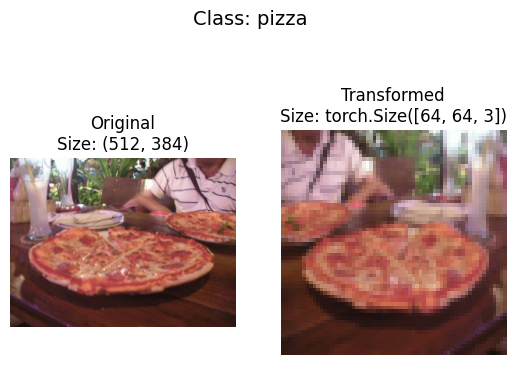

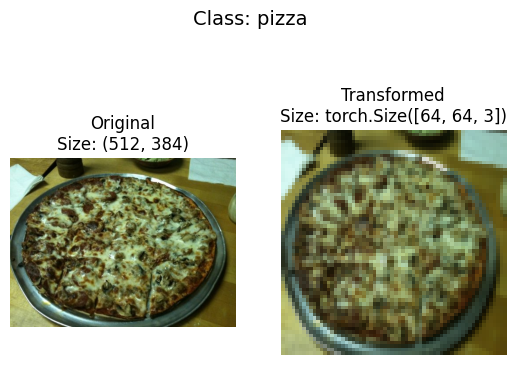

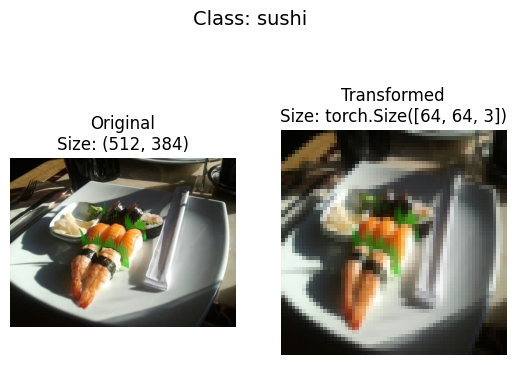

In [13]:
plot_tansformed_images(image_paths=image_path_list,
                       transform=data_transform,
                       n= 3,
                       seed=42)


## Option 1 Loading Image Data using `ImageFolder`

We can load image classicafion data using `torchvision.datasets.ImageFolder`

In [14]:
# Use ImageFolder to Create Dataset
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, #transform from the data
                                  target_transform=None) # transform for the label


test_data = datasets.ImageFolder(root=test_dir,
                                  transform=data_transform, #transform from the data
                                  target_transform=None) # transform for the label


train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [15]:
#get class attributes
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [16]:
# get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [17]:
# check length of datasets
len(train_data), len(test_data)

(225, 75)

In [18]:
# index on the train data dataset o get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f'Image Tensor:\n {img}')
print(f'Image shape: {img.shape}')
print(f'Image datatype: {img.dtype}')
print(f'Image Laebl: {label}')
print(f'Label datatype: {type(label)}')

Image Tensor:
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0

Original Shape: torch.Size([3, 64, 64])
Image Permute: torch.Size([64, 64, 3])


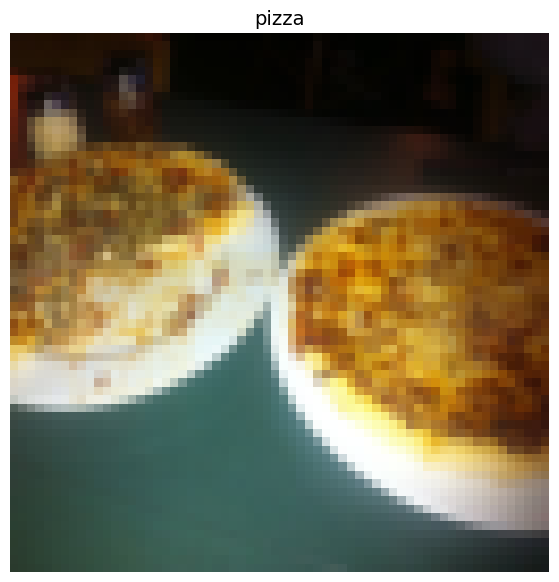

In [19]:
# rearrange the order of dimensions
img_permute = img.permute(1,2,0)

# print put different shapes
print(f'Original Shape: {img.shape}')
print(f'Image Permute: {img_permute.shape}')

# plot image
plt.figure(figsize =(10,7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize = 14);

## Turn loade images into dataloaders

1. `DataLoaders` help us to convert our dataset into an iterable and we can custmize the `batch_size` so that the model can see `batch_size` images at a time

In [20]:
# Turn train and test datasets into DataLoaders
from torch.utils.data import DataLoader

BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x78d812716410>,
 <torch.utils.data.dataloader.DataLoader at 0x78d81271e710>)

In [21]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [22]:
img, label = next(iter(train_dataloader))

# batch size is now 1 but can be changed
print(f'Image Shape: {img.shape} -> (batch_size, channel, height width)')
print(f'Label: {label.shape}')

Image Shape: torch.Size([1, 3, 64, 64]) -> (batch_size, channel, height width)
Label: torch.Size([1])


## Option 2 Loading Image Data with a custom dataset

1. want to be able to load images from file
2. want to be able to get class names from the dataset
3. want to get classes as dictionary

Pros:
* you can create a datasets out of almost anything
* Not limited to pytorch's pre built dataset functions

Cons:
* Even though you create a dataset out of almost anything, it doesn't mean it will work
* Using a custom dataset results in more code writing/performance issues

In [23]:
import os
import pathlib

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [24]:
# Instance of torchvision.datasets.ImageFolder
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Creating a helper function to get class Names

We want a function to:
1. Get the class names using `os.scandir()` to traverse a target directory
2. Raise an error if class names aren't found
3. turn the class names into a dict and list and retrn them

In [25]:
# Setup path for target directory
target_directory = train_dir
print(f'Target Dir: {target_directory}')

# Get class names from target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target Dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [26]:
def find_classes(directory: str, ) -> Tuple[list[str], Dict[str, int]]:
  '''
  Find the class folder ames in a target directory
  '''
  # 1 get class names by scanning the target directory
  classes = sorted([entry.name for entry in os.scandir(directory) if entry.is_dir()])

  # 2. Raise error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find classes in {directory}. Please check file structure")

  # 3. Create a dictionary of ndex and label
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

  return classes, class_to_idx

In [27]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset we want to:

1. subclass `torch.utils.data.Dataset
2. Init our subclass with our target directory as well as a transform if we'd like to transform our data
3. Create several attributes:
  * paths - paths of our image
  * transform - transform we'd lke to use
  * classes - a list of our classes
  * class_to_idx - a dict of our target classes mapped to integer labels
4. create a function to open an image
5. overwrite the `__len()__` method to return the length of our dataset
6. Overwrite the `__getitem()__` to return a given sample when passed an index

In [28]:
# Write a custom Dataset class
from torch.utils.data import Dataset

# 1 Subclass orch.utils.data.Datasets
class ImageFolderCustom(Dataset):
  # 2 initialize our custom Dataset
  def __init__(self, targ_dir: str, transform = None) -> None:
    # super().__init__()
    # 3 create class attributes
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # setup tranform
    self.transform = transform
    # create class and and class_to_dix
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4 Create a function that loads images
  def load_image(self, index:int) -> Image.Image:
    "Opens an image via a path and returns it"
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5 Overwrite the __len()__
  def __len__(self):
    return len(self.paths)

  # 6 Overwrite the __getitem__() method
  def __getitem__(self, index) -> Tuple[torch.Tensor, int]:
    'Returns one sample of data and label (X,y)'
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    # transform if necessary
    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx


In [29]:
# create a transform
train_transform = transforms.Compose([
                                      transforms.Resize(size = (64,64)),
                                      transforms.RandomHorizontalFlip(0.5),
                                      transforms.ToTensor()])

test_transform = transforms.Compose([
                                      transforms.Resize(size = (64,64)),
                                      transforms.ToTensor()])

In [30]:
# test out imagefolder custom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transform)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                      transform=test_transform)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x78d8127a32d0>,
 <__main__.ImageFolderCustom at 0x78d812783a10>)

In [31]:
len(train_data), len(train_data_custom)

(225, 225)

In [32]:
len(test_data), len(test_data_custom)

(75, 75)

In [33]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [34]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [35]:
# check for equality
print(train_data_custom.classes == train_data.classes)

True


### Create a Function to display random images

1. Take in a `dataset` and other parameters such as class names and how many images to visualize
2. To prevent the display from getting out of hand let's the number of images to see at 19
3. Set the random seed for reproducibity
4. Get a list of random indexes from the target dataset
5. Setup a matplotlib plot
6. Loop throught the random sample images and plot them
7. make sure the dimensions of our images line up with matplotlib

In [36]:
# 1 create function to display random images
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: list[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2 adjust display if n is too high
  if n > 10:
    n =10
    display_shape=False
    print(f'For display purposes, n should not be larger than 10 setting to 10 and removing shape display')

  # 3 set random seed for reproducibity
  if seed:
    random.seed(seed)

  # 4 get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k = n)

  #5 Setup Plot
  plt.figure(figsize=(16,8))

  # 6 Loop through the indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7 Adjust tensor dimensions for ploting
    targ_image_adjust = targ_image.permute(1,2,0)

    # 8 Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis(False)
    if classes:
      title = f'{classes[targ_label]}'
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)


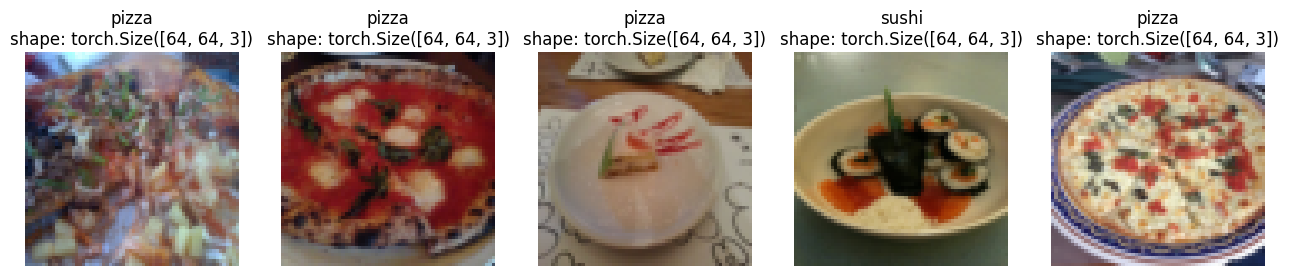

In [37]:
# display random images from mage folder
display_random_images(dataset=train_data,
                      classes=class_names,
                      n=5,
                      seed=None)

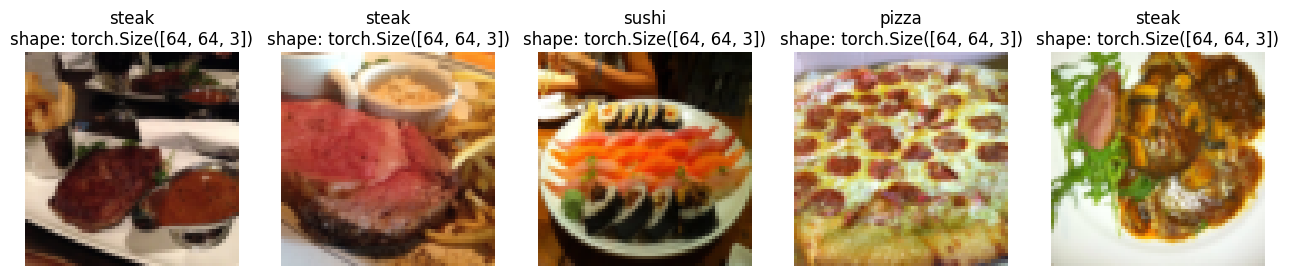

In [38]:
# display random images from cutom dataset
display_random_images(dataset=train_data_custom,
                      classes=class_names,
                      n=5,
                      seed=None)

### Create a Dataloader from the custom Dataset

In [39]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=1,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset= test_data_custom,
                                    batch_size = BATCH_SIZE,
                                    num_workers=1,
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x78d81244b190>,
 <torch.utils.data.dataloader.DataLoader at 0x78d812421a50>)

In [40]:
# get img and label
image_custom, label_custom = next(iter(train_dataloader_custom))

# print out the shapes
image_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## Other Forms of Transforms Data Augmentation

Data augmentation is the process of artificially adding diversity to your training data

In the case of image data, this may mean applying various image transfomrations to the training data

Let's take a look at one type of augmentation used to train pytorch vision models to state of the art



In [41]:
# Let's look at trivial augment
from torchvision import  transforms
train_transform = transforms.Compose([
    transforms.Resize(size = (224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size = (224,224)),
    transforms.ToTensor()
])

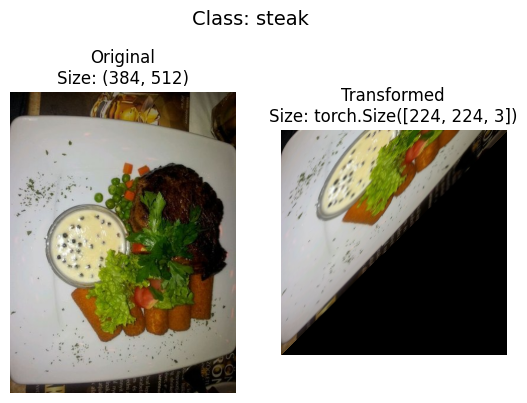

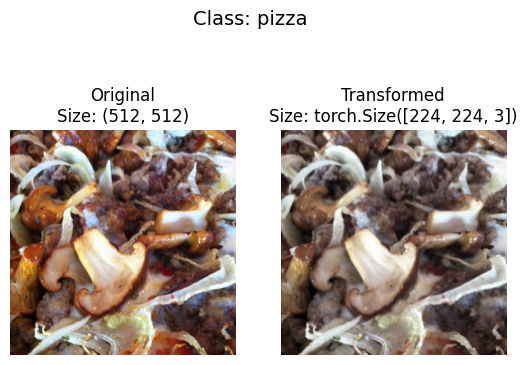

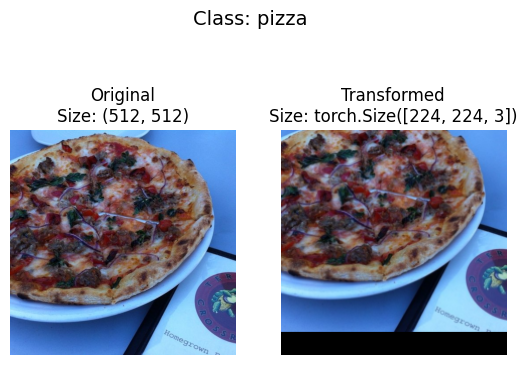

In [42]:
# ge all image paths and plot
plot_tansformed_images(image_paths=image_path_list,
                       transform=train_transform,
                       n=3,
                       seed=None)


## Model 0: TinyVGG model

let's replicate the tinyVGG model architecture

In [43]:
# Create transforms and load data
simple_tranform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [44]:
# load the data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                          transform=simple_tranform,
                                          )

test_data_simple = datasets.ImageFolder(root=test_dir,
                                         transform=simple_tranform)

train_data_simple, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [45]:
# create a data loader
from torch.utils.data import DataLoader
import os

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_simple = DataLoader(train_data_simple,
                                      batch_size=BATCH_SIZE,
                                      shuffle=True,
                                      num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=False,
                                    num_workers=NUM_WORKERS)



### Create TinyVGG model class

In [46]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )

  def forward(self, x ):
    x = self.conv_block_1(x)
    # print(x.shape)
    x= self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x

In [47]:
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

### Try a forward pass on a single image

In [48]:
# get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [49]:
# try a forward pass
model_0(image_batch.to(device))

tensor([[-0.0254, -0.0336,  0.0182],
        [-0.0251, -0.0335,  0.0165],
        [-0.0297, -0.0334,  0.0198],
        [-0.0286, -0.0334,  0.0239],
        [-0.0299, -0.0316,  0.0241],
        [-0.0251, -0.0368,  0.0231],
        [-0.0242, -0.0332,  0.0194],
        [-0.0251, -0.0343,  0.0212],
        [-0.0253, -0.0343,  0.0185],
        [-0.0300, -0.0354,  0.0180],
        [-0.0303, -0.0354,  0.0199],
        [-0.0290, -0.0352,  0.0207],
        [-0.0322, -0.0323,  0.0271],
        [-0.0237, -0.0335,  0.0193],
        [-0.0266, -0.0334,  0.0228],
        [-0.0246, -0.0357,  0.0170],
        [-0.0297, -0.0335,  0.0209],
        [-0.0247, -0.0349,  0.0167],
        [-0.0303, -0.0392,  0.0203],
        [-0.0240, -0.0349,  0.0189],
        [-0.0250, -0.0350,  0.0187],
        [-0.0279, -0.0349,  0.0183],
        [-0.0300, -0.0338,  0.0213],
        [-0.0324, -0.0328,  0.0227],
        [-0.0265, -0.0337,  0.0173],
        [-0.0329, -0.0314,  0.0189],
        [-0.0243, -0.0328,  0.0172],
 

### use torchinfo to get a summary of the shapes going through our model model

In [50]:
#install torchinfo and import if available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size = (1,3,64,64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

## Create a train and trst loop function

`train-step()` - takes in a model and sataloader and trains the model on the dataloader

`test-step()` - takes in a model and dataloader and evaluates the model on the dataloader

In [51]:
# create trainstep
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device= device):
  # put in train mode
  model.to(device)
  model.train()

  # setup train loss and accuracy
  train_loss, train_acc = 0, 0

  # loop through data_loader and batches
  for batch, (X,y) in enumerate(data_loader):
    # send data to device
    X, y = X.to(device), y.to(device)

    # forward pass
    y_pred = model(X)

    # calculate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # Optimizer zero_grad
    optimizer.zero_grad()

    # loss backward
    loss.backward()

    # optimizer step
    optimizer.step()

    # calculate the accuracy and accumulate it
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim = 1), dim =1)
    train_acc += (y_pred_class==y).sum().item() / len(y_pred)

  # adjust metrics to get avg loss per batch
  train_loss = train_loss / len(data_loader)
  train_acc = train_acc / len(data_loader)
  return train_loss, train_acc


In [52]:
# create test loop function
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device = device):
  # put model in eval mode
  model.to(device)
  model.eval()

  # setup test loss and tess accuracy
  test_loss, test_acc = 0,0

  # turn on inference mode
  with torch.inference_mode():
    # loop through data loader batches
    for batch, (X, y) in enumerate(data_loader):
      # send data to target device
      X, y = X.to(device), y.to(device)

      # forward pass
      test_pred_logits = model(X)

      # cal loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # calculate the accuracy
      test_pred_labels = test_pred_logits.argmax(dim = 1)
      test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))

  # adjust metrics per batch
  test_loss /= len(data_loader)
  test_acc /= len(data_loader)
  return test_loss, test_acc

### Create a train function to combine `train_step()` and `test_step()`





In [53]:
from tqdm.auto import tqdm

# create a train function
def train(model:torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer,
          epochs: int = 5,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          device = device):

  # create empty results dictionary
  results = {'train_loss': [],
             'train_acc': [],
             'test_loss': [],
             'test_acc':[]}

  # loop through epochs
  for epoch in tqdm(range(epochs)):
    # print(f'Epoch: {epoch}\n-----------')
    train_loss, train_acc = train_step(model=model,
                                        data_loader=train_dataloader,
                                        loss_fn=loss_fn,
                                        optimizer=optimizer,
                                       device = device)

    test_loss, test_acc = test_step(model=model,
                                    data_loader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device = device)

    # print what's happening
    print(f'Epoch: {epoch} | train loss: {train_loss:.4f} | Tarin acc {train_acc:.4f} | test loss: {test_loss:.4f}| Test acc: {test_acc:.4f}')

    # update results dict
    results['train_loss'].append(train_loss)
    results['train_acc'].append(train_acc)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)

  # return the results
  return results


### Train and Evaluate Model 0

In [54]:
# set random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# get the number of epochs
NUM_EPOCHS = 5

# recreate an instance of tin vgg
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

# set loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                            lr=0.001)

# start the timer
from timeit import default_timer as timer
start_time = timer()

# train model 0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# end timer
end_timer = timer()
print(f'Total Training time: {end_timer - start_time:.3f} seconds')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | train loss: 1.1063 | Tarin acc 0.3047 | test loss: 1.0983| Test acc: 0.3011
Epoch: 1 | train loss: 1.0998 | Tarin acc 0.3281 | test loss: 1.0697| Test acc: 0.5417
Epoch: 2 | train loss: 1.0869 | Tarin acc 0.4883 | test loss: 1.0808| Test acc: 0.4924
Epoch: 3 | train loss: 1.0844 | Tarin acc 0.3984 | test loss: 1.0607| Test acc: 0.5833
Epoch: 4 | train loss: 1.0662 | Tarin acc 0.4219 | test loss: 1.0656| Test acc: 0.5644
Total Training time: 13.255 seconds


### Plot the loss Curves of Model 0

A loss curve is a way of tracking your model's performance over time

In [55]:
# get model 0 keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [56]:
def plot_loss_curves(results: dict[str, list[float]]):
  '''Plots training curves of a esults dictionary'''
  # get the loss values of the results dictionary
  loss = results['train_loss']
  test_loss = results['test_loss']

  # get the accuracy values
  acc = results['train_acc']
  test_acc = results['test_acc']

  # figure out how many epochs
  epochs = range(len(results['train_loss']))

  # setup a plot
  plt.figure(figsize = (15,7))

  # plot the loss
  plt.subplot(1,2,1)
  plt.plot(epochs , loss, label = 'Train Loss')
  plt.plot(epochs , test_loss, label = 'Test Loss')
  plt.title('Loss')
  plt.xlabel('Epoch')
  plt.legend()

  # plot accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs , acc, label = 'Train Accuracy')
  plt.plot(epochs , test_acc, label = 'Test Accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epoch')
  plt.legend()




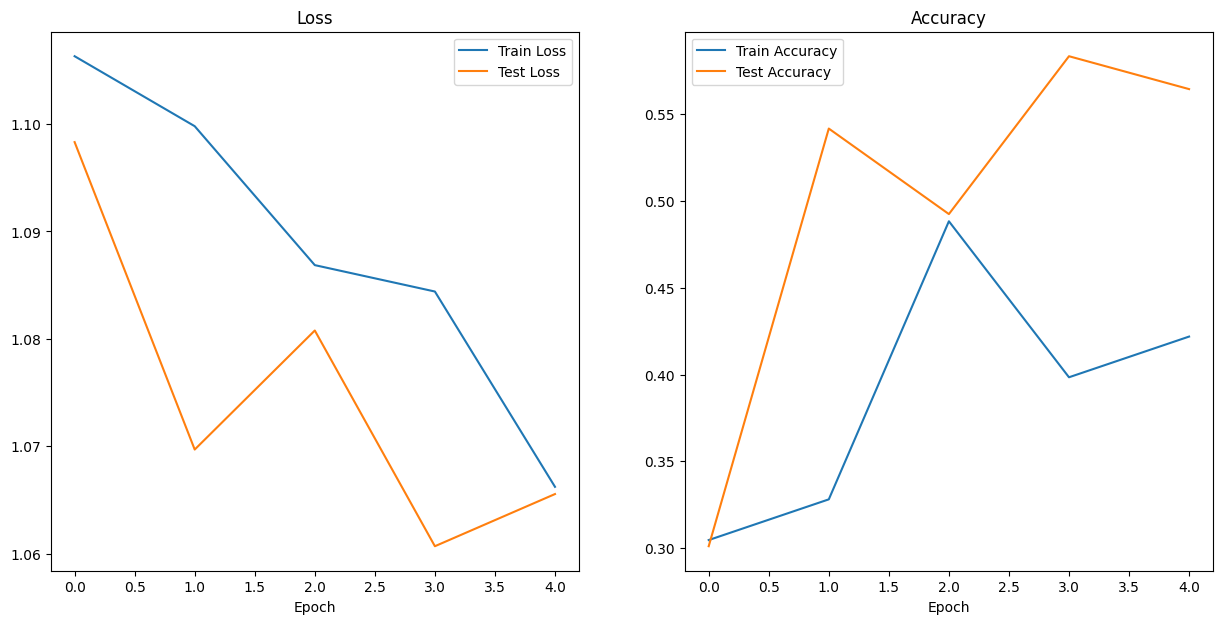

In [57]:
plot_loss_curves(model_0_results)

## Model 1 - TinyVGG with data augmentation




### Crate a transform with data augmentation

In [58]:
# Create a transform with trivialAugment
from torchvision import transforms

train_transform_trivial = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins = 31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.ToTensor()
])

### Create test and train datasets and dataloaders


In [59]:
# Turn images folders into datasets

from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=test_transform_simple)

In [60]:
# turn datsets into dataloaders
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)

train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size = BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

### Construct and train model 1

We're using the same architecture but train with augmented data

In [61]:
# create model 1
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [62]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set epchs
NUM_EPOCHS = 5

# loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr = 0.001)

# start the timer
from timeit import default_timer as timer
start_time = timer()

# train model 1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

# end timer
end_timer = timer()
print(f'Total Training time: {end_timer - start_time:.3f} seconds')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | train loss: 1.1049 | Tarin acc 0.2500 | test loss: 1.1019| Test acc: 0.2604
Epoch: 1 | train loss: 1.0807 | Tarin acc 0.4258 | test loss: 1.1261| Test acc: 0.2604
Epoch: 2 | train loss: 1.0712 | Tarin acc 0.4258 | test loss: 1.1592| Test acc: 0.2604
Epoch: 3 | train loss: 1.1254 | Tarin acc 0.3047 | test loss: 1.1581| Test acc: 0.2604
Epoch: 4 | train loss: 1.0857 | Tarin acc 0.4258 | test loss: 1.1551| Test acc: 0.3333
Total Training time: 16.348 seconds


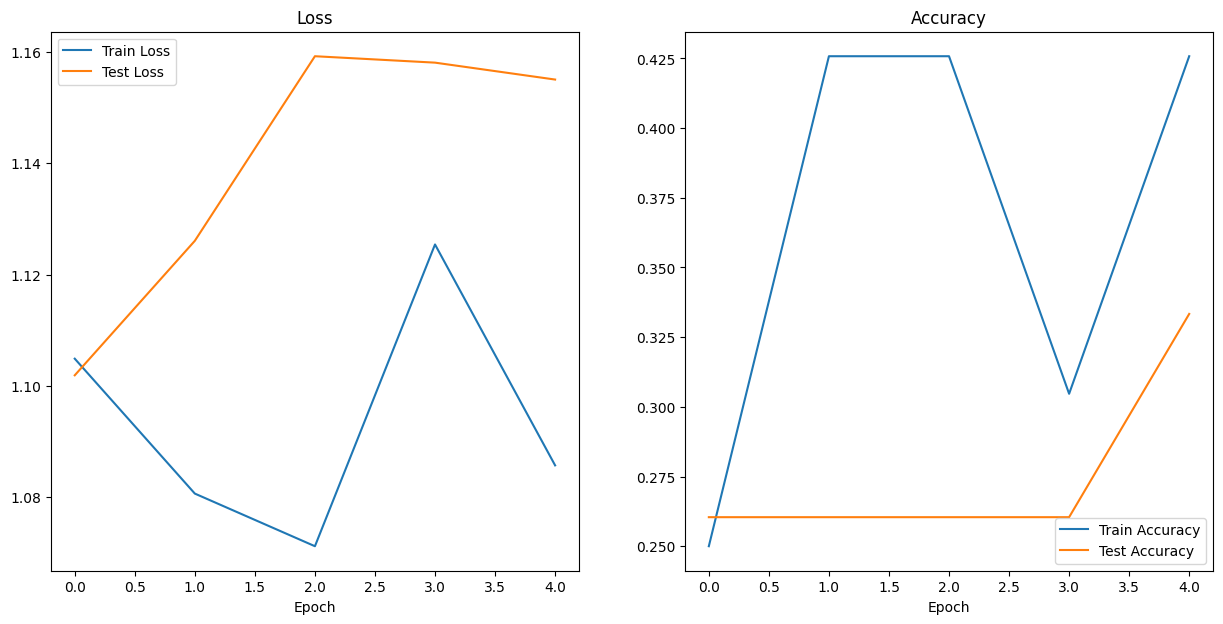

In [63]:
plot_loss_curves(model_1_results)

## Comparing Model esults

After evaluating our model  experiments, it's important to evalate them side by side

There are different ways to do this
1. Hard coding
2. Pytorch TensorBoard
3. Weights and Biases
4. ML Flow

In [64]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.106319,0.304688,1.098323,0.301136
1,1.099804,0.328125,1.069696,0.541667
2,1.086868,0.488281,1.080781,0.492424
3,1.084410,0.398438,1.060695,0.583333
4,1.066226,0.421875,1.065552,0.564394


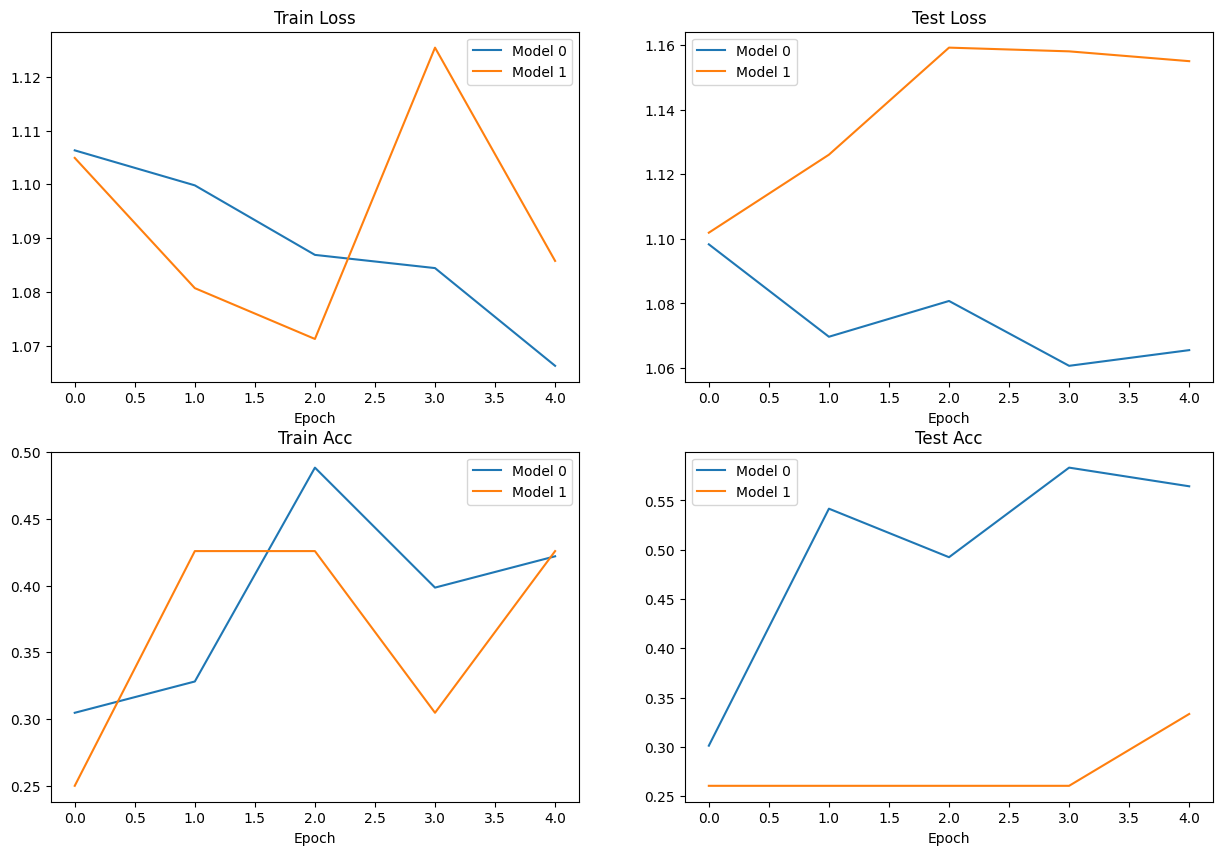

In [65]:
# setup a plot
plt.figure(figsize = (15,10))

# get number of epochs
epochs = range(len(model_0_df))

# plot train loss
plt.subplot(2,2,1)
plt.plot(epochs, model_0_df['train_loss'], label = 'Model 0')
plt.plot(epochs, model_1_df['train_loss'], label = 'Model 1')
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df['test_loss'], label='Model 0')
plt.plot(epochs, model_1_df['test_loss'], label='Model 1')
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df['test_acc'], label='Model 0')
plt.plot(epochs, model_1_df['test_acc'], label='Model 1')
plt.title('Test Acc')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df['train_acc'], label='Model 0')
plt.plot(epochs, model_1_df['train_acc'], label='Model 1')
plt.title('Train Acc')
plt.xlabel('Epoch')
plt.legend()

## Making Prediction ona custom Image

In [66]:
# Download a custom image
import requests

# Setup custome image path
custom_image_path = data_path / '04-pizza-dad.jpeg'

# download image if doesn't exist
if not custom_image_path.is_file():
  with open(custom_image_path, 'wb') as f:
    # when downloading from github use the raw link
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/04-pizza-dad.jpeg?raw=true')
    print(f'Downloading {custom_image_path}')
    f.write(request.content)
else:
  print('File already exist')


### Loading in a Custom image into Pytorch

We have to make sure our custom image is in the same form as the training data:

* In tensor form with datatype (torch.float)
* image shape (64,64)
* On the rigt device

In [70]:
import torchvision

# read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))


In [71]:
print(f'Custom Image Tensor:\n {custom_image_uint8}')
print(f'Custom Image Shape: {custom_image_uint8.shape}')
print(f'Custom Image Datatpye: {custom_image_uint8.dtype}')

Custom Image Tensor:
 tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom Image Shape: torch.Size([3, 4032, 3024])
Custom Image Data

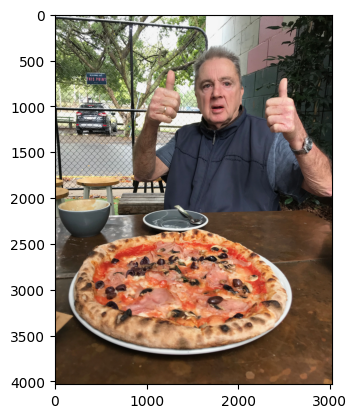

In [72]:
plt.imshow(custom_image_uint8.permute(1,2,0));

### Making a Prediction on a Custom Image

In [73]:
# make a prediction on an image in uint format

# model_1.eval()
# with torch.inference_mode():
#   model_1(custom_image_uint8.to(device))

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [76]:
# load in custom image and convert to torch.float
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255.
custom_image

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

In [ ]:
# creata a transform pipeline to resize the image
custom_image_transform = transforms.Compose([
    transforms.Resize(size = (64,64))
])



RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x756765 and 1690x3)

In [78]:
# creata a transform pipeline to resize the image
custom_image_transform = transforms.Compose([
    transforms.Resize(size = (64,64))
])

# transfor target target image
custom_image_transformed = custom_image_transform(custom_image)

# print shapes
print(f'Original SHape: {custom_image.shape}')
print(f'Transformed Shape: {custom_image_transformed.shape}')

Original SHape: torch.Size([3, 4032, 3024])
Transformed Shape: torch.Size([3, 64, 64])


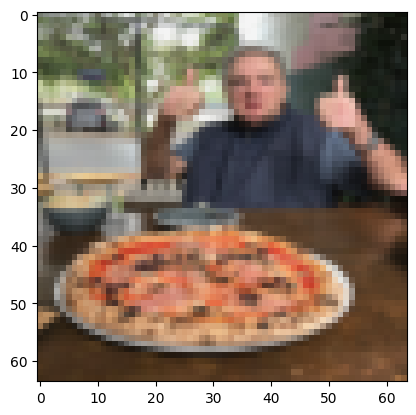

In [79]:
plt.imshow(custom_image_transformed.permute(1,2,0));

In [80]:
# This will error - No Batch Size

# model_1.eval()
# with torch.inference_mode():
#   model_1(custom_image_transformed.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x169 and 1690x3)

In [81]:
model_1.eval()
with torch.inference_mode():
  custom_image_preds = model_1(custom_image_transformed.unsqueeze(0).to(device))
custom_image_preds

tensor([[ 0.0798,  0.0357, -0.2083]], device='cuda:0')

In [82]:
# convert logits to predicition probabilities
custom_image_pred_probs = torch.softmax(custom_image_preds, dim = 1)
custom_image_pred_probs

tensor([[0.3695, 0.3535, 0.2770]], device='cuda:0')

In [83]:
# convert probabilties to predicition labels
custom_image_pred_labels = torch.argmax(custom_image_pred_probs, dim = 1)
custom_image_pred_labels

tensor([0], device='cuda:0')

In [84]:
class_names[custom_image_pred_labels]

'pizza'

### Putting Custom Image Predicition together - Building a Function

Ideal Outcome
* Function where we pass an image path, make a prediciton and plot the image

Function steps:
1. We need to import the image using torchvision.io
2. Transform the image so that it is in the same format as the training data and add an extra dimension for the number of batches
3. Make a prediction
4. Plot the image with the prediction as the title

In [130]:
def make_predicition(image_file: str,
                     model: nn.Module,
                     device: str = device):
  # convert img file to tensor
  loaded_image = load_image(image_file)

  # transform tensor
  transformed_image = transform_image(loaded_image)

  # make prediction
  pred = get_label(transformed_image, model_1)

  # plot results
  plot_results(label=pred, image = loaded_image)


def load_image(imgae_file: str) -> torch.Tensor:
  if type(imgae_file) == str:
    tensor = torchvision.io.read_image(imgae_file)
  tensor = torchvision.io.read_image(str(imgae_file))
  return tensor

def transform_image(image: torch.Tensor) -> torch.Tensor:
  transform = transforms.Compose([
      transforms.Resize(size = (64,64))
  ])
  transformed_image = transform(image)
  return transformed_image.type(torch.float32) /255.

def get_label(image: torch.Tensor,
                    model: nn.Module,
                    device: str = device) -> torch.Tensor:

  model.to(device)
  model.eval()
  with torch.inference_mode():
    logits = model(image.unsqueeze(0).to(device))
    probs = torch.softmax(logits, dim=1)
    pred = torch.argmax(probs, dim =1)
  label = class_names[pred]
  return label

def plot_results(label: str, image: torch.Tensor):
  label = label
  plt.imshow(image.permute(1,2,0))
  plt.title(f'Prediction: {label.upper()}')
  plt.axis(False)


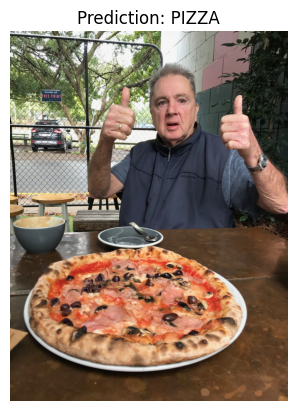

In [131]:
make_predicition(custom_image_path, model_1)